In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset
import sys
import matplotlib.pyplot as plt
from IPython import display

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# transformations
transform = T.Compose([ T.ToTensor(),
                        T.Normalize(.5,.5),
                       ])

dataset = torchvision.datasets.FashionMNIST(root='./data', download=True, transform=transform)

In [4]:
print(dataset.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [5]:
classes_keep = ['Trouser','Sneaker','Pullover']

images_use = torch.Tensor()
for i in range(len(classes_keep)):
  idx = dataset.classes.index(classes_keep[i])
  images_use = torch.cat( (images_use,torch.where(dataset.targets==idx)[0]), 0).type(torch.long)
  print(f'class {classes_keep[i]} : index {idx}')

batch_size = 128
sampler = torch.utils.data.sampler.SubsetRandomSampler(images_use)
data_loader = DataLoader(dataset,sampler=sampler,batch_size=batch_size,drop_last=True)

class Trouser : index 1
class Sneaker : index 7
class Pullover : index 2


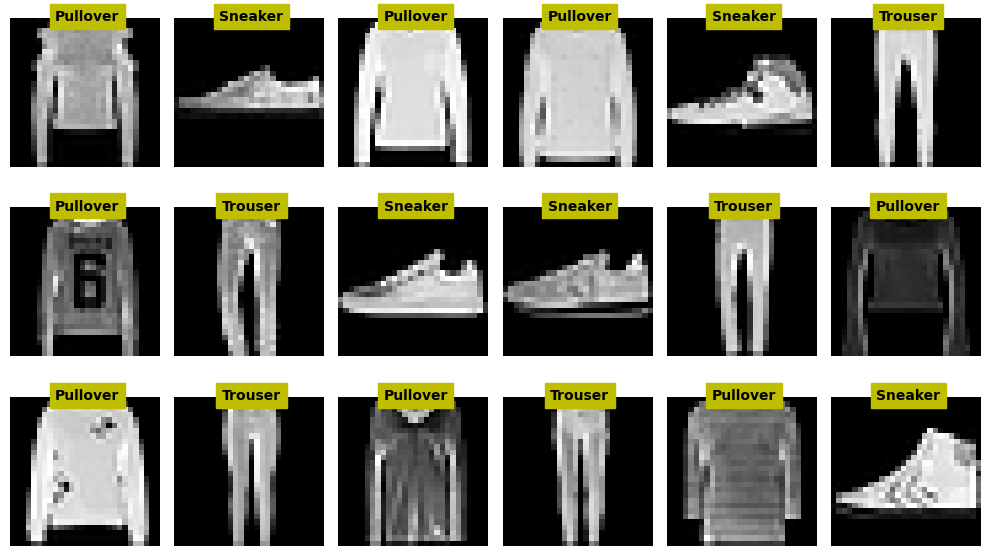

In [6]:
X, y = next(iter(data_loader))
fig,axs = plt.subplots(3,6,figsize=(10,6))
for (i,ax) in enumerate(axs.flatten()):

  pic = torch.squeeze(X.data[i])
  pic = pic/2 + .5
  
  label = dataset.classes[y[i]]

  ax.imshow(pic,cmap='gray')
  ax.text(14,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, 1)

    def forward(self,x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.out(x)
        return torch.sigmoid(x)

discriminator = Discriminator()
y = discriminator(torch.randn(10,784))
y

tensor([[0.4699],
        [0.4884],
        [0.4832],
        [0.5108],
        [0.4600],
        [0.4852],
        [0.5043],
        [0.5184],
        [0.4553],
        [0.4420]], grad_fn=<SigmoidBackward0>)

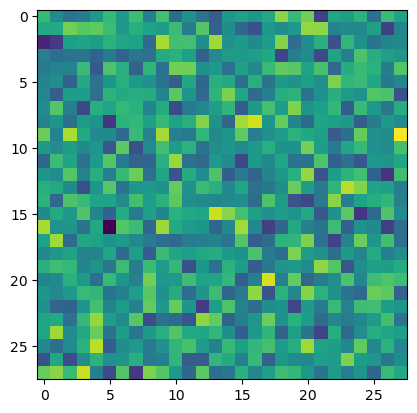

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(64, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, 784)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.out(x)
        return torch.tanh(x)

generator = Generator()
y = generator(torch.randn(10,64))
plt.imshow(y[0,:].detach().squeeze().view(28,28))

In [9]:
loss_fun = nn.BCELoss()

discriminator = Discriminator().to(device)
generator = Generator().to(device)

d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=.0002)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=.0002)

In [10]:
EPOCHS = int(100_000 / len(data_loader))

losses = np.zeros((EPOCHS * len(data_loader), 2))
counter = 0

for i in range(EPOCHS):
    for data, _ in data_loader:
        data = data.view(batch_size, -1).to(device)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # discriminator
        pred_real = discriminator(data)
        d_loss_real = loss_fun(pred_real, real_labels)

        fake_images = generator(torch.randn(batch_size, 64).to(device))
        pred_fake = discriminator(fake_images)
        d_loss_fake = loss_fun(pred_fake, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        losses[counter, 0] = d_loss.item()

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
    
        # generator
        fake_images = generator(torch.randn(batch_size, 64).to(device))
        pred_fake = discriminator(fake_images)

        g_loss = loss_fun(pred_fake, real_labels)
        losses[counter, 1] = g_loss.item()

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        counter += 1

    if (i+1) % 10 == 0:
        print(f"Epoch {i+1} of {EPOCHS}: d_loss = {d_loss}, g_loss = {g_loss}")

Epoch 10 of 714: d_loss = 0.09891480207443237, g_loss = 5.308487892150879
Epoch 20 of 714: d_loss = 0.116036556661129, g_loss = 6.742918968200684
Epoch 30 of 714: d_loss = 0.25008073449134827, g_loss = 4.93416690826416
Epoch 40 of 714: d_loss = 0.4121280908584595, g_loss = 3.4635140895843506
Epoch 50 of 714: d_loss = 0.12805260717868805, g_loss = 6.082518577575684
Epoch 60 of 714: d_loss = 0.252201646566391, g_loss = 3.4489262104034424
Epoch 70 of 714: d_loss = 0.33691921830177307, g_loss = 3.20706844329834
Epoch 80 of 714: d_loss = 0.2339707314968109, g_loss = 4.7365498542785645
Epoch 90 of 714: d_loss = 0.4352354109287262, g_loss = 3.3659963607788086
Epoch 100 of 714: d_loss = 0.48910418152809143, g_loss = 3.0473716259002686
Epoch 110 of 714: d_loss = 0.6331349611282349, g_loss = 2.783395290374756
Epoch 120 of 714: d_loss = 0.4112444818019867, g_loss = 3.106386184692383
Epoch 130 of 714: d_loss = 0.3449009358882904, g_loss = 2.7087044715881348
Epoch 140 of 714: d_loss = 0.56627529859

In [11]:
def smooth(x, k = 5):
    return np.convolve(x, np.ones(k)/k, mode = 'same')

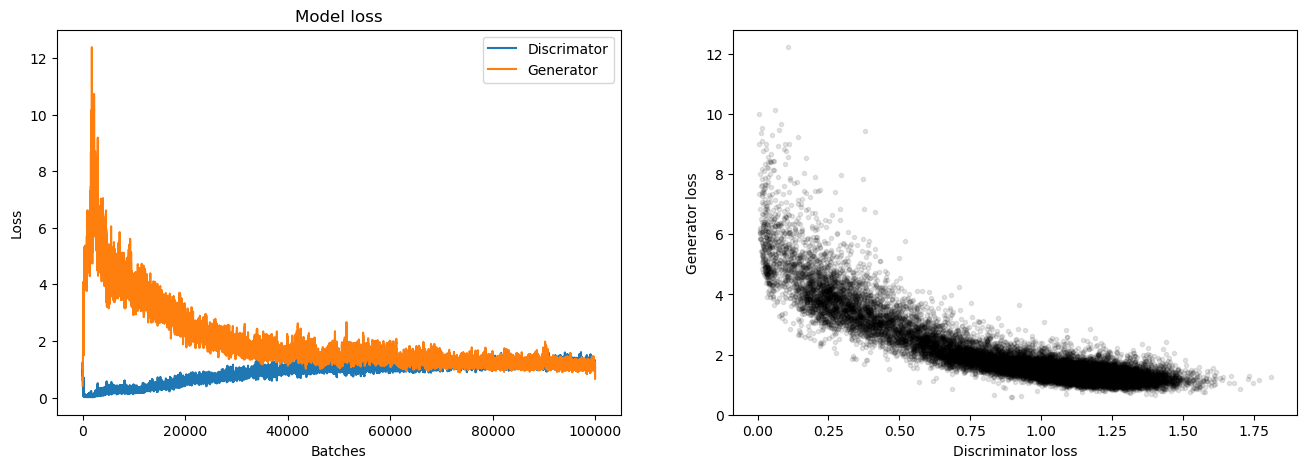

In [12]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(smooth(losses[:,0]))
ax[0].plot(smooth(losses[:,1]))
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

plt.show()

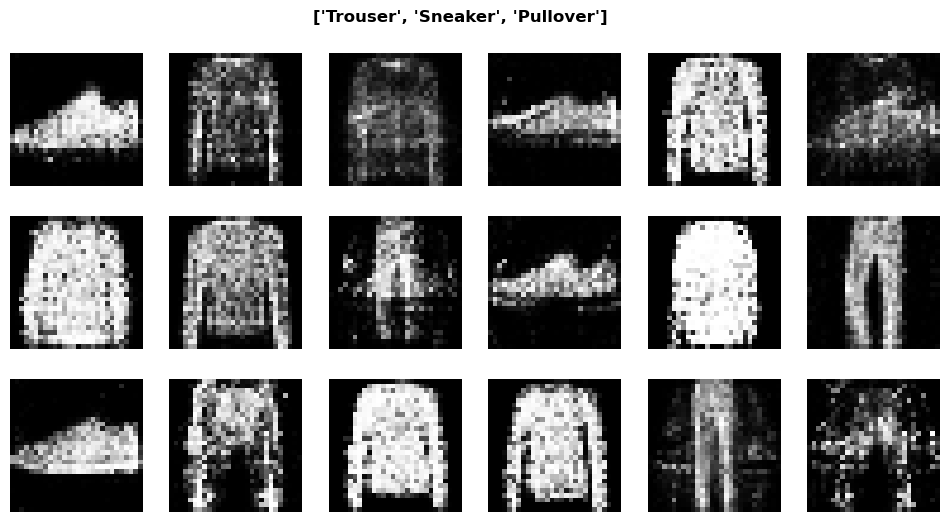

In [13]:
generator.eval()
fake_data = generator(torch.randn(18,64).to(device)).cpu()

# and visualize...
fig,axs = plt.subplots(3,6,figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,:,].detach().view(28,28),cmap='gray')
  ax.axis('off')

plt.suptitle(classes_keep,y=.95,fontweight='bold')
plt.show()